<a href="https://colab.research.google.com/github/benai9916/computer-vision-assignment/blob/main/bipolar_factory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [280]:
import gdown
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout, LSTM, MaxPool1D, Embedding,\
SpatialDropout1D, Bidirectional, Conv1D
from keras.optimizers import RMSprop
from keras.initializers import GlorotUniform
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [4]:
!gdown --id 1XmFdxusKSNGVDBHYcNo71dmgda0aYVPf

Downloading...
From: https://drive.google.com/uc?id=1XmFdxusKSNGVDBHYcNo71dmgda0aYVPf
To: /content/CVAssignmentDataset.csv
11.8MB [00:00, 37.5MB/s]


## Load data

In [232]:
# read data

df =  pd.read_csv('/content/CVAssignmentDataset.csv')

In [233]:
# sneek peek at the data

df.head(2)

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...


In [234]:
# size of the data

df.shape

(86461, 2)

In [235]:
# check the data type

df.dtypes

Class    object
Text     object
dtype: object

In [236]:
# check class ratio

df['Class'].value_counts()

0                          44392
1                          42068
https://t.co/sbSljdw1Zw        1
Name: Class, dtype: int64

In [237]:
# we have one unwanted classs

df = df[~(df['Class'] == 'https://t.co/sbSljdw1Zw')]

In [238]:
df.shape

(86460, 2)

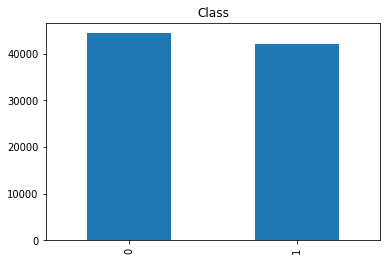

In [239]:
# plot the class

df['Class'].value_counts().plot(kind='bar', title='Class')

## Text Preprocessing

In [240]:
stop_words = stopwords.words('english')
stemmer =  SnowballStemmer('english')

# remove username and links
text_cleaning_re =  "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [241]:
def preprocess(text, stem=False):
    # remove user name and links
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()

    # remove 'RT' beore the user name
    text = re.sub(r'\brt\b\s+', '', text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [242]:
df['Text'] = df['Text'].apply(lambda x : preprocess(x))

In [243]:
df.head()

,Class,Text
0,1,today senate dems vote savetheinternet proud s...
1,1,winterhavensun winter resident alta vista teac...
2,1,nbclatino repdarrensoto noted hurricane maria ...
3,1,nalcabpolicy meeting repdarrensoto thanks taki...
4,1,vegalteno hurricane season starts june 1st pue...


## Visualize the words in class

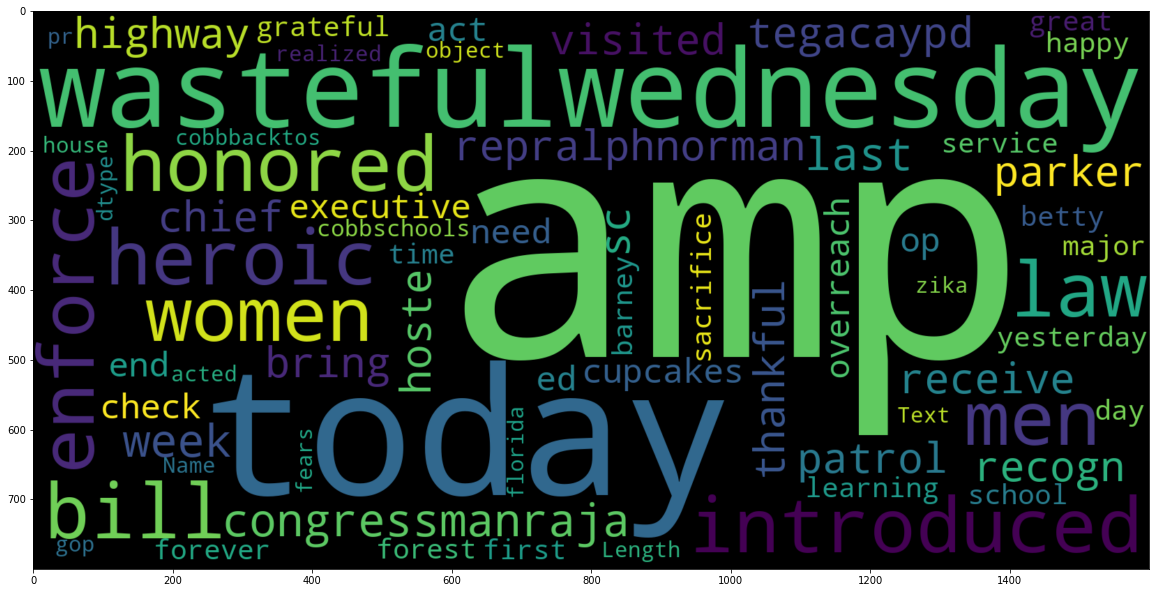

In [244]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words=2000, width = 1600, height = 800).generate(str(df[df['Class'] == '0'].Text))
plt.imshow(wc , interpolation = 'bilinear')

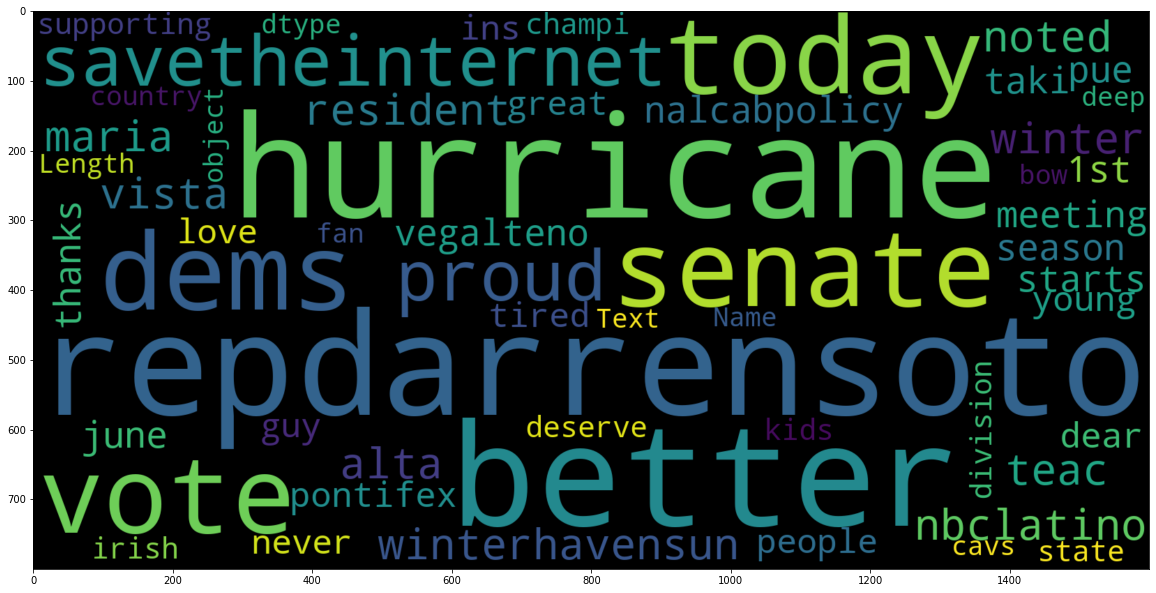

In [245]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words=2000, width = 1600, height = 800).generate(str(df[df['Class'] == '1'].Text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [246]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50

In [247]:
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE ,random_state=7)
 
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

Train Data size: 69168
Test Data size: 17292


## Word Emdedding

In [248]:
document = [d.split() for d in train_data['Text']]

In [249]:
document[1]

['may',
 'national',
 'foster',
 'care',
 'month',
 'member',
 'congressional',
 'caucus',
 'foster',
 'youth',
 'proud',
 'renew']

In [261]:
word2vec_model = gensim.models.word2vec.Word2Vec(size= 32, window=7, workers=6, min_count=10)

word2vec_model.build_vocab(document)

word = word2vec_model.wv.vocab.keys()

vocab_size = len(word)

print("Vocab size", vocab_size)

Vocab size 7907


In [262]:
word2vec_model.train(document, epochs=32, total_examples=len(document))

(20489442, 24045312)

In [263]:
word2vec_model.most_similar('earth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('beauty', 0.7271630764007568),
 ('planet', 0.7176234722137451),
 ('beautiful', 0.6607822775840759),
 ('ge', 0.6494221091270447),
 ('earthday', 0.636728823184967),
 ('slavery', 0.6214364767074585),
 ('holy', 0.6199520826339722),
 ('independence', 0.6177732944488525),
 ('perfect', 0.6114438772201538),
 ('findyourpark', 0.5928888320922852)]

## Tokenize

In [264]:
from keras.preprocessing.text import Tokenizer

tokenize = Tokenizer()

tokenize.fit_on_texts(train_data['Text'])
word_index = tokenize.word_index

vocab_size = len(tokenize.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 52646


## Sequence of word

In [265]:
# create sequence of word
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenize.texts_to_sequences(train_data['Text']), maxlen=MAX_SEQUENCE_LENGTH)

x_test = pad_sequences(tokenize.texts_to_sequences(test_data['Text']), maxlen=MAX_SEQUENCE_LENGTH)

In [266]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  136,   33, 1689,   99,  208,  230,
         55,  401, 1689,  795,   23, 1573], dtype=int32)

In [267]:
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (69168, 50)
Testing X Shape: (17292, 50)


## Encoding

In [316]:
labels = train_data['Class'].unique().tolist()

In [335]:
y_train = train_data['Class'].astype(int)
y_test = test_data['Class'].astype(int)

## Embedding

In [336]:
EMBEDDING_DIM = 32
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 20

In [337]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        
print(embedding_matrix.shape)

(52646, 32)


# Model Training

In [366]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                                   input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)(sequence_input)

x = Conv1D(32, 1, activation='relu')(embedding_layer)
x = MaxPool1D(2)(x)
x = Bidirectional(LSTM(256, dropout=0.2, return_sequences=True, recurrent_dropout=0.2, input_shape=(1, 1)))(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2))(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

x = Dense(512, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, outputs)

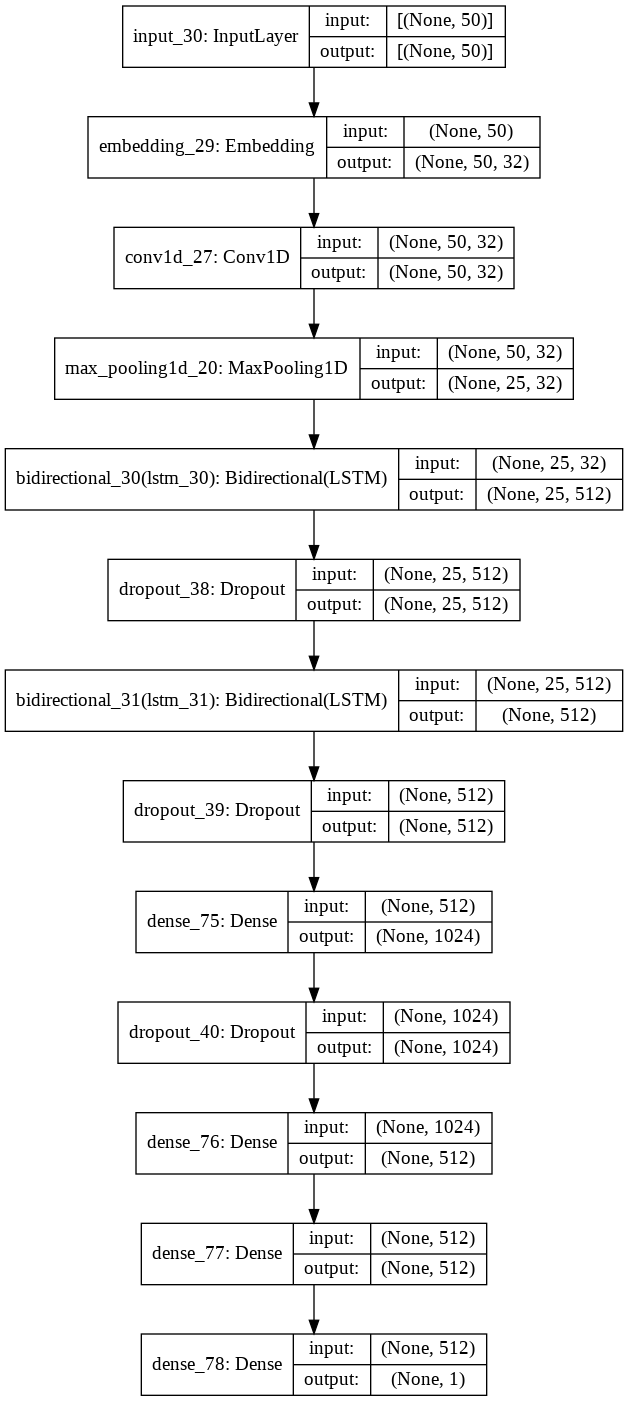

In [367]:
plot_model(model, show_shapes=True)

In [368]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',metrics=['accuracy'])

my_callbacks = [
    ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1),
    EarlyStopping(patience=3),
]

In [369]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=my_callbacks)

Epoch 1/20
68/68 [==============================] - 41s 487ms/step - loss: 0.6490 - accuracy: 0.6078 - val_loss: 0.5833 - val_accuracy: 0.6764
Epoch 2/20
68/68 [==============================] - 32s 468ms/step - loss: 0.5850 - accuracy: 0.6743 - val_loss: 0.5719 - val_accuracy: 0.6890
Epoch 3/20
68/68 [==============================] - 32s 467ms/step - loss: 0.5672 - accuracy: 0.6892 - val_loss: 0.5593 - val_accuracy: 0.6968
Epoch 4/20
68/68 [==============================] - 32s 471ms/step - loss: 0.5544 - accuracy: 0.6982 - val_loss: 0.5428 - val_accuracy: 0.7058
Epoch 5/20
68/68 [==============================] - 32s 465ms/step - loss: 0.5427 - accuracy: 0.7043 - val_loss: 0.5356 - val_accuracy: 0.7078
Epoch 6/20
68/68 [==============================] - 32s 469ms/step - loss: 0.5344 - accuracy: 0.7118 - val_loss: 0.5286 - val_accuracy: 0.7149
Epoch 7/20
68/68 [==============================] - 32s 470ms/step - loss: 0.5279 - accuracy: 0.7173 - val_loss: 0.5248 - val_accuracy: 0.7151

In [373]:
def decode_sentiment(score):
    return '0' if score>0.5 else '1'


scores = model.predict(x_test)
y_pred_1d = [decode_sentiment(score) for score in scores]

In [374]:
from sklearn.metrics import classification_report

print(classification_report(list(test_data['Class']), y_pred_1d))

              precision    recall  f1-score   support

           0       0.29      0.28      0.28      8840
           1       0.26      0.26      0.26      8452

    accuracy                           0.27     17292
   macro avg       0.27      0.27      0.27     17292
weighted avg       0.27      0.27      0.27     17292



In [375]:
from sklearn.metrics import accuracy_score

In [376]:
accuracy_score(list(test_data['Class']), y_pred_1d)

0.2719176497802452

### Accuracy is quite low, we can change the model architecture and see it might improve the accuracy